Họ tên: Bùi Trường Giang, Phạm Đức Huy, Đỗ Xuân Sang

MSSV: 19120497, 19120534, 19120637

# Project: Seam carving

Với các GPU tương đối mới thì để biên dịch chỉ cần dùng câu lệnh: \
`nvcc tên-file.cu -o tên-file-chạy`

Nhưng trên Colab mình thường lấy được GPU khá cũ là Tesla K80 với compute capability (phiên bản phần cứng) là 3.7; để biên dịch đúng với GPU khá cũ này thì bạn cần dùng câu lệnh: \
`nvcc -arch=sm_37 tên-file.cu -o tên-file-chạy` \
Trong đó, 37 chính là compute capability của GPU Tesla K80.

Để phòng trường hợp khi làm bài bạn lấy được GPU có compute capability x.x nhưng khi chấm bài Thầy lại lấy được GPU có compute capability khác x.x, dưới đây mình sẽ có đoạn code Python để tự động lấy 2 con số ứng với compute capability của GPU và lưu vào 2 biến `major` và `minor`:


In [ ]:
from numba import cuda
major, minor = cuda.get_current_device().compute_capability
print(f'GPU compute capability: {major}.{minor}')

GPU compute capability: 7.5


Một khi đã chạy đoạn code Python ở trên, để biên dịch thì bạn sẽ dùng câu lệnh: \
`nvcc -arch=sm_{major}{minor} tên-file.cu -o tên-file-chạy`

Dưới đây, khi làm bài thì bạn có thể tùy ý thêm/xóa cell. Đừng xóa mấy cell có chữ của Thầy là được.

In [ ]:
# Đoạn code Python để hiển thị file ảnh pnm ở notebook
# Ví dụ để hiển thị file "img.pnm", ở dòng cuối của code cell
# bạn gõ (không cần dấu ! đằng trước): show_pnm('img.pnm')
# LƯU Ý: bạn phải chạy cell này một lần thì mới gọi được hàm show_pnm
from PIL import Image
import numpy as np
def show_pnm(file_name):
  with open(file_name, 'r') as f:
    vals = f.read().split()
  w = int(vals[1])
  h = int(vals[2])
  if vals[0] == 'P2': # Grayscale
    pixels = np.array(vals[4:], dtype=np.uint8).reshape((h, w))
  elif vals[0] == 'P3': # RGB
    pixels = np.array(vals[4:], dtype=np.uint8).reshape((h, w, 3))
  else:
    return None
  
  return Image.fromarray(pixels)

# Đoạn code Python để hiển thị file chứa ma trận ở notebook
# (một dòng của ma trận ứng với một dòng trong file, 
# các phần tử trên mỗi dòng được cách nhau bởi khoảng trắng) 
# Ví dụ để hiển thị file "pixel_importance.txt", ở dòng cuối của code cell
# bạn gõ: show_matrix('pixel_important.txt')
def show_matrix(matrix_file):
  m = np.loadtxt(matrix_file)
  m = m + m.min()
  m = m / m.max()
  m = m * 255
  m = m.astype(np.uint8)
  return Image.fromarray(m)

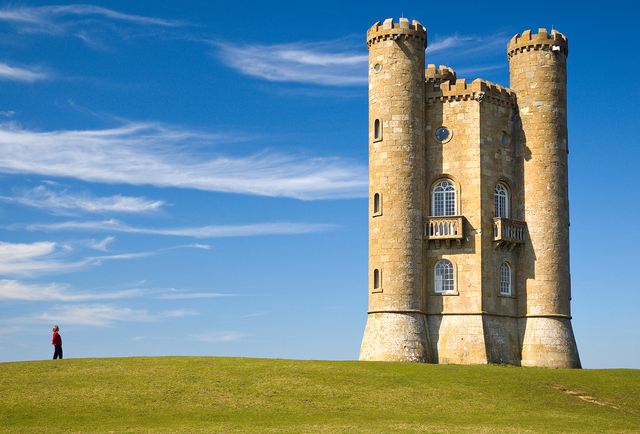

In [ ]:
show_pnm('in.ppm')

# Version 1: Sequential

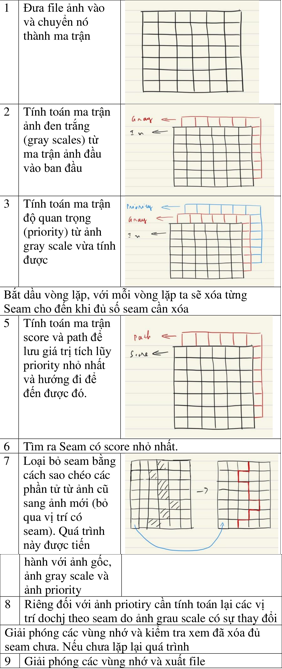

In [ ]:
!nvcc -arch=sm_{major}{minor} ver1_seq.cu -o ver1_seq

In [ ]:
!./ver1_seq in.ppm out.pnm 100

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15843721216 bytes
CMEM: 65536 bytes
L2 cache: 4194304 bytes
SMEM / one SM: 65536 bytes
****************************

Image size (width x height): 640 x 434
Number of seam removed: 100

Processing time (use host): 438.769257 ms



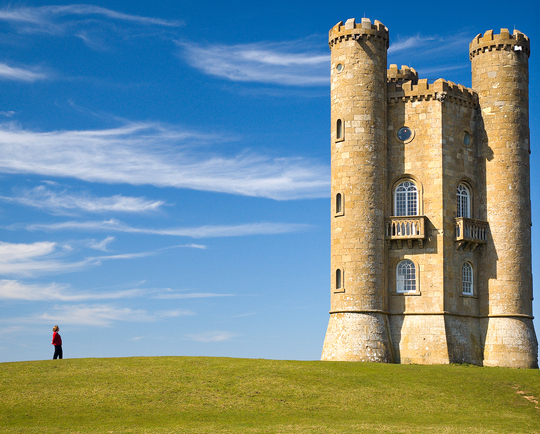

In [ ]:
show_pnm('out_host.pnm')

# Version 2: 
- Song song hóa quá trình gray scale giống như đã làm ở homework 1

In [ ]:
!nvcc -arch=sm_{major}{minor} ver2_par.cu -o ver2_par

In [ ]:
!./ver2_par in.ppm out.pnm 100

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15843721216 bytes
CMEM: 65536 bytes
L2 cache: 4194304 bytes
SMEM / one SM: 65536 bytes
****************************

Image size (width x height): 640 x 434
Number of seam removed: 100

Processing time (use host): 444.686401 ms

Processing time (use device): 430.650482 ms

Error between device result and host result: 0.000000


# Version 3:
- Song song hóa quá trình tính độ quan trọng tương tự như việc blur image như đã làm ở homework 3

In [ ]:
!nvcc -arch=sm_{major}{minor} ver3_par.cu -o ver3_par

In [ ]:
!./ver3_par in.ppm out.pnm 100

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15843721216 bytes
CMEM: 65536 bytes
L2 cache: 4194304 bytes
SMEM / one SM: 65536 bytes
****************************

Image size (width x height): 640 x 434
Number of seam removed: 100

Processing time (use host): 465.250214 ms

Processing time (use device): 421.746826 ms

Error between device result and host result: 0.000000


# Version 4: 
**Song song quá trình score và path trên từng hàng của ảnh:** </br>
Quá trình tính toán score và path gần như chỉ thực hiện trên từng hàng (độ phức tạp sẽ là width*height đối với host do phải tính toán lần lượt từng phần tử trên hàng) </br>
=> Do đó ta có thể song song hóa quá trình này bằng việc song song tính toán score và path theo từng hàng (song song các ô trong cùng một hàng). (độ phức tạp giảm còn lại height).

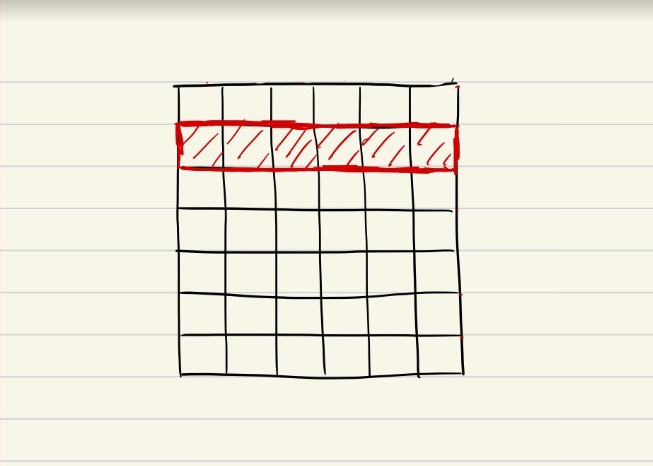

In [ ]:
!nvcc -arch=sm_{major}{minor} ver4_par.cu -o ver4_par

In [ ]:
!./ver4_par in.ppm out.pnm 100

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15843721216 bytes
CMEM: 65536 bytes
L2 cache: 4194304 bytes
SMEM / one SM: 65536 bytes
****************************

Image size (width x height): 640 x 434
Number of seam removed: 100

Processing time (use host): 726.591492 ms

Processing time (use device): 990.810913 ms

Error between device result and host result: 0.000000


## Sử dụng ảnh với kích thước width lớn (5000px)

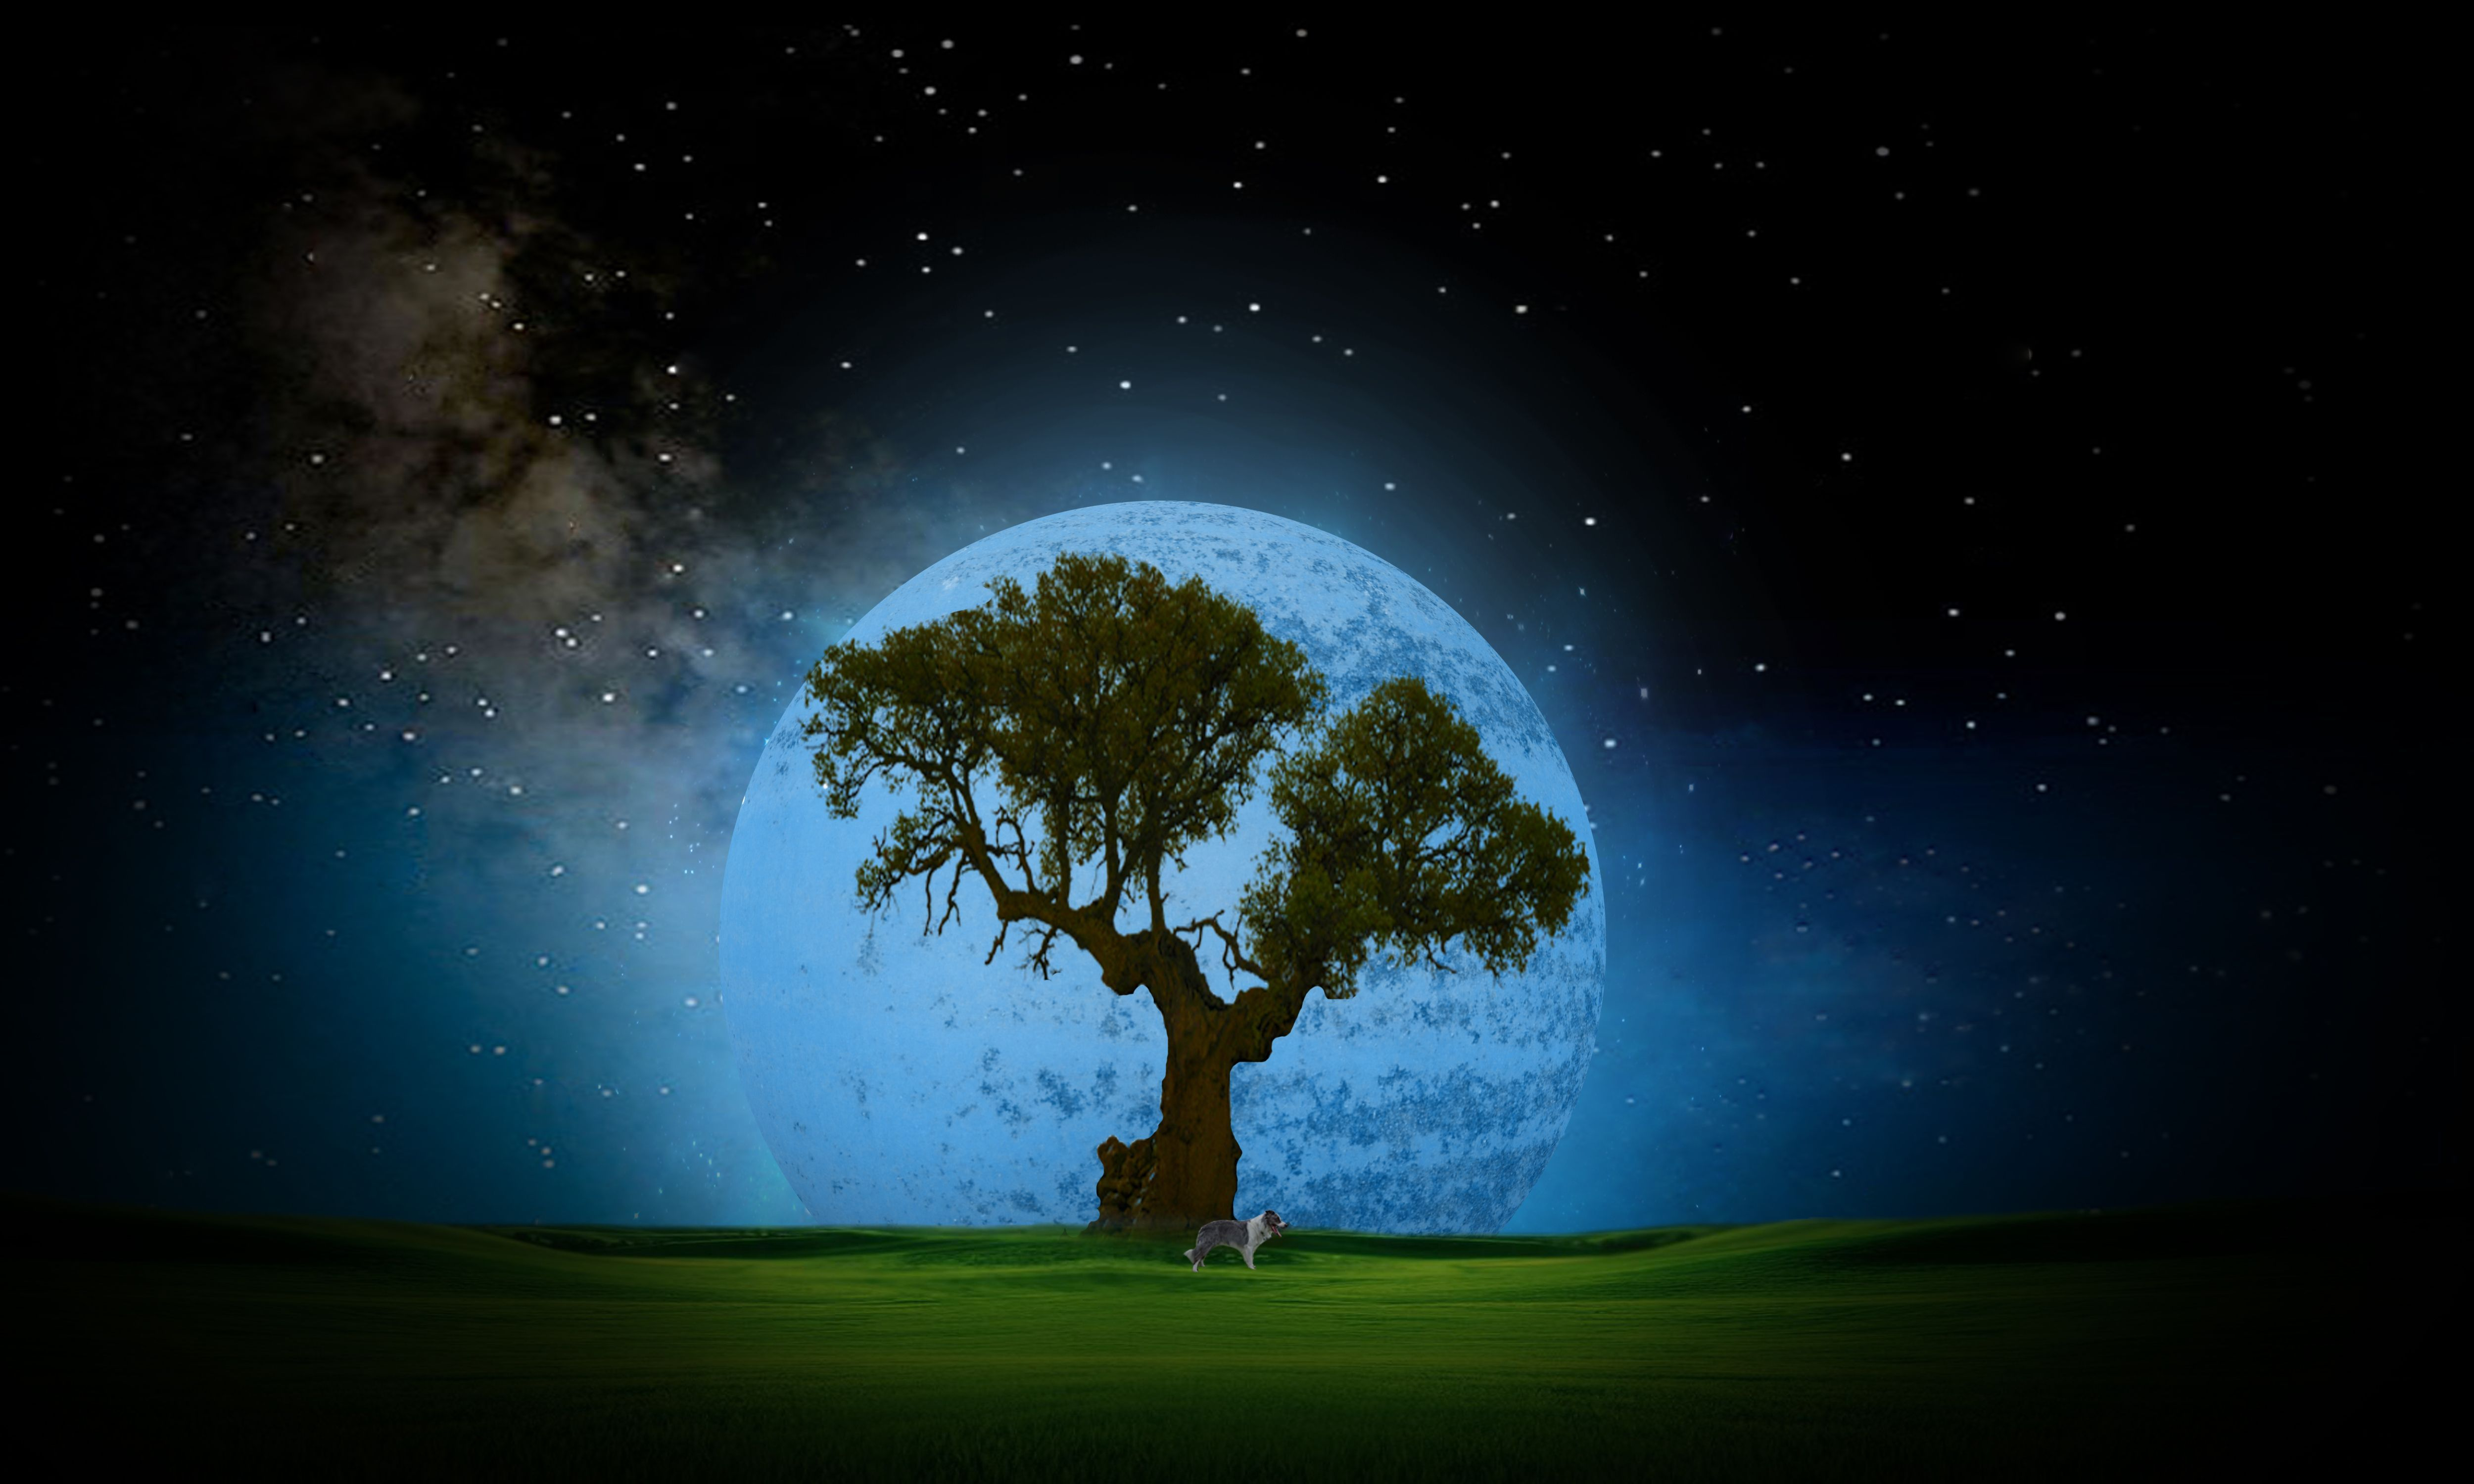

In [ ]:
show_pnm('in2.ppm')

## Chạy thử với version 3

In [ ]:
!./ver3_par in2.ppm out.pnm 100

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15843721216 bytes
CMEM: 65536 bytes
L2 cache: 4194304 bytes
SMEM / one SM: 65536 bytes
****************************

Image size (width x height): 5000 x 3000
Number of seam removed: 100

Processing time (use host): 23379.800781 ms

Processing time (use device): 21900.503906 ms

Error between device result and host result: 0.000000


## So sánh với version 4

In [ ]:
!./ver4_par in2.ppm out.pnm 100

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15843721216 bytes
CMEM: 65536 bytes
L2 cache: 4194304 bytes
SMEM / one SM: 65536 bytes
****************************

Image size (width x height): 5000 x 3000
Number of seam removed: 100

Processing time (use host): 23266.533203 ms

Processing time (use device): 12918.982422 ms

Error between device result and host result: 0.000000


# Version 5: 
**Song song quá trình copy các seam từ ảnh gốc sang ảnh mới(remove seam):** </br>
Sau khi đã có được đường seam, ta thực hiện xóa đường seam bằng cách copy tất cả các phần tử còn lại (trừ đường seam) vào ảnh mới. Với cách cài đặt thông thường quá trình này sẽ thường có độ phức tạp là k*height. Nhận thấy quá trình copy các phần tử này là độc lập với nhau. Do đó, ta sẽ song song hóa quá trình này bằng cách song song quá trình giữa cách hàng với nhau. Độ phức tạp sẽ giảm xuống còn height + k.

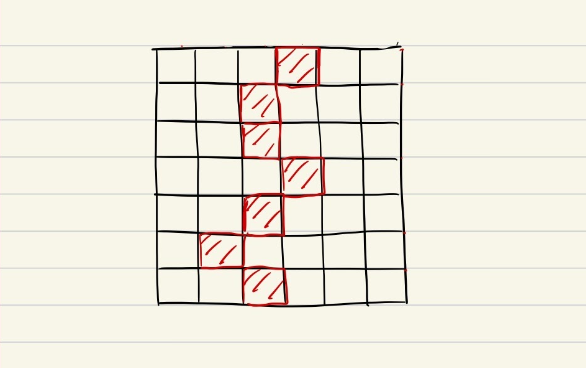

In [ ]:
!nvcc -arch=sm_{major}{minor} ver5_par.cu -o ver5_par

In [ ]:
!./ver5_par in2.ppm out.pnm 100

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15843721216 bytes
CMEM: 65536 bytes
L2 cache: 4194304 bytes
SMEM / one SM: 65536 bytes
****************************

Image size (width x height): 5000 x 3000
Number of seam removed: 100

Processing time (use host): 23138.519531 ms

Processing time (use device): 8172.186035 ms

Error between device result and host result: 0.000000


# Nhìn lại quá trình làm đồ án
- Những khó khăn:
  - Trong quá trình thực hiện code tuần tự xuất hiện một vài bug nhỏ về bộ nhớ và rất khó fix
  - Chưa có nhiều kinh nghiệm trong việc code chương trình song song
- Những bài học:
  - Hiểu thêm về thuật toán seam carving
  - Cách làm một chương trình song song phải trải qua
- Nếu có thêm thời gian:
  - Chúng em sẽ áp dụng smem vào v5 để tính toán lại priority
  - Tối ưu hóa lại source code và áp dụng các thuật toán seam carving khác gradient hoặc heuristic,...
  - Ngoài việc thay đổi giảm kích thước thì có thể nghiên cứu quá trình thay đổi tăng kích thước theo cả chiều dọc lẫn chiều ngang.

# Tài liệu tham khảo
1. https://github.com/baopdh/Seam-Carving
2. https://www.aryan.app/seam-carving/
3. https://github.com/kalpeshdusane/Seam-Carving-B.E.-Project